In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
import numpy as np
np.set_printoptions(precision=3)
%precision 3
start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data(window=2)
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_2_vecDim100
loading data...
36994 36994 11776 11776 0 0
took:  0.27970457077026367


In [4]:
from tensorflow.keras import *

In [5]:
# Build the model
print('Build model...')
model = Sequential()
model.add(layers.LSTM(256, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(512, return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(256))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))
model.add(layers.Dense(units=len(labels)))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

batch_size=64
history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=(x_test, y_test))

2020-08-31 12:05:39 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build model...
Train on 36994 samples, validate on 11776 samples


2020-08-31 12:05:41 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
36994/36994 [==============================] - 100s 3ms/sample - loss: 0.8144 - acc: 0.7062 - val_loss: 0.6222 - val_acc: 0.7894
Epoch 2/5
36994/36994 [==============================] - 91s 2ms/sample - loss: 0.5568 - acc: 0.8015 - val_loss: 0.5518 - val_acc: 0.8111
Epoch 3/5
36994/36994 [==============================] - 93s 3ms/sample - loss: 0.4887 - acc: 0.8280 - val_loss: 0.5020 - val_acc: 0.8242
Epoch 4/5
36994/36994 [==============================] - 87s 2ms/sample - loss: 0.4457 - acc: 0.8451 - val_loss: 0.4614 - val_acc: 0.8342
Epoch 5/5
36994/36994 [==============================] - 87s 2ms/sample - loss: 0.4151 - acc: 0.8544 - val_loss: 0.4435 - val_acc: 0.8479


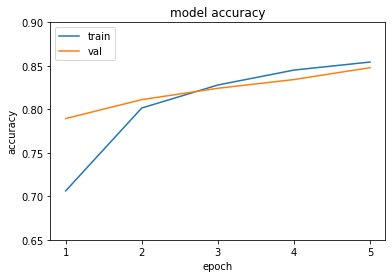

In [6]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.65,0.9)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
# predict test data
y_pred = model.predict(x_test)

In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = prepare_training_data.one_hot_to_labels(y_pred)
true_label = prepare_training_data.one_hot_to_labels(y_test)

print('class distribution test data + predicted')
print('-----------------------------------')
for i, label in enumerate(labels):
    print(i,label,':',np.sum(true_label==i), 'pred: ',np.sum(pred_label==i))

In [9]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.790268 | 0.285714 |    0.563008 |     0.588191 |  0.979381 |      0.789407 |    0.828386 |  0.930725 |
| recall    |     0.872222 | 0.322581 |    0.383126 |     0.734405 |  0.859729 |      0.829139 |    0.828386 |  0.917155 |
| f1        |     0.829225 | 0.30303  |    0.455967 |     0.653216 |  0.915663 |      0.808786 |    0.828386 |  0.92389  |
f1 average:  0.714770296077256
f1 average:  0.6464349666141179
Precision average:  0.7193851064220952
recall average:  0.7183427092359833
acc 0.8479110054347826


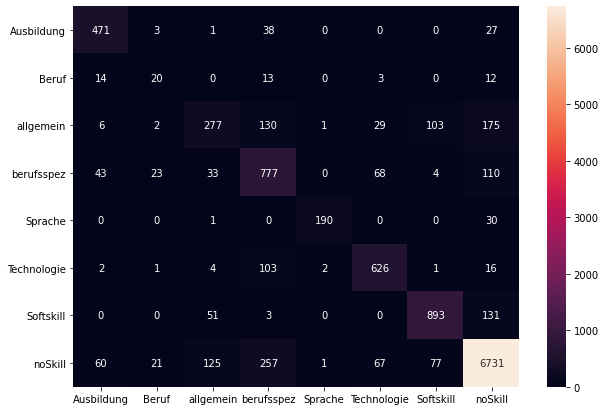

In [10]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [11]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  6731


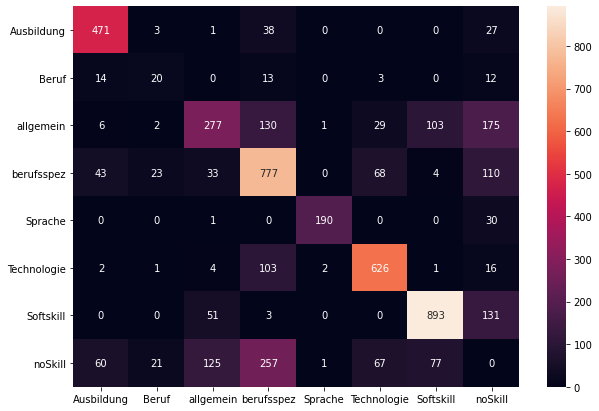

In [12]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')